# NLP and Sentiment Analysis

Using data from CrowdFlower, I'm going to perform different NLP models and sentiment analysis on tweets talking about Apple and Google.

Should I make this two datasets? Begin by seperating tweets into pandas dataframes, one for google, one of apple. The business understanding could be a 3rd party service acting to relay the sentiment of each companies products based on tweets. I will give advertising and marketing reccomendations to each of the companies.

Reminder - This is a classification task

Preliminary thoughts on process - 
1. prepreperation - vectorize all tweets at start
2. Classify all tweets as positive, negative, neutral
3. exploration - Begin exploring products that are discussed positive or negatively and check word associativity to determine the reasons for those sentiments. 
4. Give advertising recommendations - Advertising recommendations: Marketing research shows we should advertise to people who like our products. If twitter is generally positive, suggest more money spent on advertising, if twitter is generally negative, perhaps less money should be spent. Or considering advertising that highlights the best aspects of the discussed products, and counters/discusses the improvements of negatively talked about products.
5. Give product development recommendations - Overwhelmingly negatively talked about products should be improved based on user feedback, determine most discussed feedback

In [22]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize

#Sklearn
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

In [23]:
stopwords_list = stopwords.words('english')

In [24]:
# create df with data and inspect
df = pd.read_csv('data-Copy1.csv', engine='python')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [25]:
# Change column names for ease of use
df.columns = ['tweet', 'subject', 'emotion']

In [26]:
# Check emotion distribution 
df['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [27]:
# Store any unknown emotion values elsewhere and then drop them from the main DF
# We can potentially use this later as a production version of the learner to give these tweets an emotion

unknowns_df = df.loc[df['emotion'] == "I can't tell"]

df = df.drop(unknowns_df.index.tolist())

In [28]:
# Check NaNs
df.isna().sum()

tweet         1
subject    5655
emotion       0
dtype: int64

The number NaN's in the subject column is a bit alarming. I can't really do any simple Imputing to reduce that number, and I can drop over half my dataset. Either have to live with it and move on, or iterate through the df and see if the creators of the data missed things. Could perhaps just use an If/Then to check is if a group of apple or apple related words is in the tweet and assign that tweet to apple, same with google.

In [29]:
#Drop NaN values only if tweet is NaN
df = df.dropna(subset=['tweet'])
df.isna().sum()

tweet         0
subject    5654
emotion       0
dtype: int64

In [30]:
df.head()

,tweet,subject,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [31]:
# Lower case all tweets
df['tweet'] = df['tweet'].str.lower()

In [32]:
df.subject.value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: subject, dtype: int64

In [33]:
#investigate other google product tweets
google_rows = df[df['subject'] == 'Other Google product or service']
google_rows

,tweet,subject,emotion
13,gotta love this #sxsw google calendar featurin...,Other Google product or service,Positive emotion
27,someone started an #austin @partnerhub group i...,Other Google product or service,Positive emotion
163,just left #sxsw tradeshow demo of @mention at ...,Other Google product or service,Positive emotion
198,sweet new 3-d google maps demo going on in bal...,Other Google product or service,Positive emotion
199,more than 35 million miles per day are driving...,Other Google product or service,Positive emotion
...,...,...,...
8989,it's crazy how much culture is documented in g...,Other Google product or service,Positive emotion
8992,looks very interesting rt@mention google to la...,Other Google product or service,Positive emotion
9006,creativity prompt: use google maps to virtuall...,Other Google product or service,Positive emotion
9025,absolutely! rt @mention timely good schtuff f...,Other Google product or service,Positive emotion


I think for now, its ok to just impute the missing values based on Apple, iPhone, iPad, Google, or Andriod, and not worry too much about the related products until later. Later I can use word association to find tweets with 'app' in them as well to further expand subject

In [34]:
# # Impute NaN values in subject because things were missed
 
# apple words
df.loc[df['tweet'].str.contains('apple', case=False) & df['subject'].isna(), 'subject'] = 'Apple'
df.loc[df['tweet'].str.contains('iphone', case=False) & df['subject'].isna(), 'subject'] = 'iPhone'
df.loc[df['tweet'].str.contains('ipad', case=False) & df['subject'].isna(), 'subject'] = 'iPad'
df.loc[df['tweet'].str.contains('itunes', case=False) & df['subject'].isna(), 'subject'] = 'iPad or iPhone App'

# google
df.loc[df['tweet'].str.contains('google', case=False) & df['subject'].isna(), 'subject'] = 'Google'

# andriod
df.loc[df['tweet'].str.contains('andriod', case=False) & df['subject'].isna(), 'subject'] = 'Andriod'



In [35]:
#check NaN again
df.isna().sum()

tweet        0
subject    907
emotion      0
dtype: int64

That was a massive massive success. Lets move on to tokenizing and removing stopwords

In [36]:
# Tokenize Tweets

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

df["tweet_tokenized"] = df["tweet"].apply(tokenizer.tokenize)

# Display full text
#df.style.set_properties(**{'text-align': 'left'})

In [37]:
#remove stopwords

# this helper funtion returns a list with any stopwords in the original list removed
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [w for w in token_list if w not in stopwords_list]

df["tweet_without_stopwords"] = df["tweet_tokenized"].apply(remove_stopwords)

I think now would be a good time to create frequency distributions for any Apple related tweets, google related tweets, and then again with positive, negative, and no emotion tweets

In [38]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

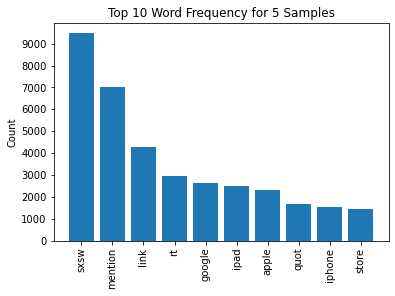

In [39]:
entire_df__freq_dist = FreqDist(df["tweet_without_stopwords"].explode())
visualize_top_10(entire_df__freq_dist, "Top 10 Word Frequency for 5 Samples")

It might be worth removing sxsw, mention, link, and rt as well. They don't give me any information.

1. #sxsw is the tech event most of these tweets are talking about
2. mention refers quoting someone
3. link refers to links in tweets
4. rt refers to a retweet
5. quot refers to a quote retweet
6. amp refers to an ampersand


In [40]:
stopwords_list.append('sxsw')
stopwords_list.append('mention')
stopwords_list.append('link')
stopwords_list.append('rt')
stopwords_list.append('quot')
stopwords_list.append('amp')
df["tweet_without_stopwords"] = df["tweet_tokenized"].apply(remove_stopwords)

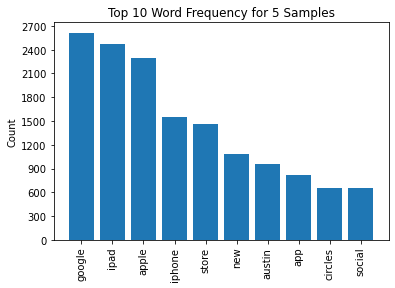

In [41]:
entire_df__freq_dist = FreqDist(df["tweet_without_stopwords"].explode())
visualize_top_10(entire_df__freq_dist, "Top 10 Word Frequency for 5 Samples")

In [42]:
df.subject.value_counts()

Google                             2093
iPad                               1916
Apple                              1841
iPhone                             1166
iPad or iPhone App                  527
Other Google product or service     292
Android App                          81
Android                              78
Other Apple product or service       35
Name: subject, dtype: int64

In [43]:
# Function that iterates through the different Subjects and plots their distributions

def freq_distribution_by_subject(df):
    #subjects = ['Google', 'iPad', 'Apple', 'iPhone', 'iPad or iPhone App']
    subjects = set(df['subject'].values.tolist())
    subjects.pop()

    #in the loop, create a freq dist for only a subject, then call the visualize freq dist
    
    for sub in subjects:
        print(sub)
        subject_df = df[df['subject'] == sub]
        subject_df_freq_dist = FreqDist(subject_df["tweet_without_stopwords"].explode())
        visualize_top_10(subject_df_freq_dist, sub)

iPad or iPhone App
Android
iPhone
Google
Other Google product or service
Other Apple product or service
Android App
Apple
iPad


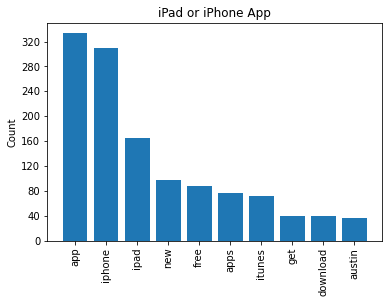

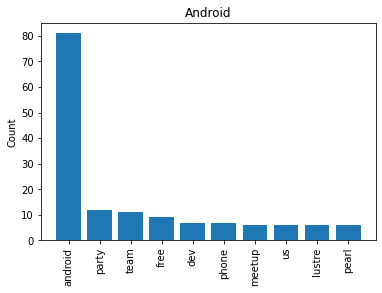

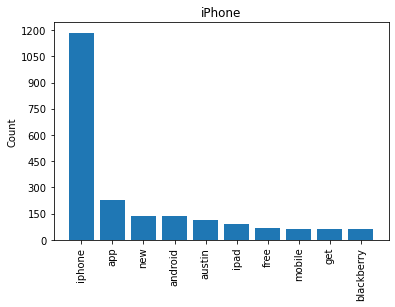

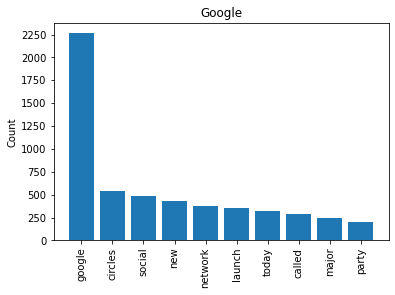

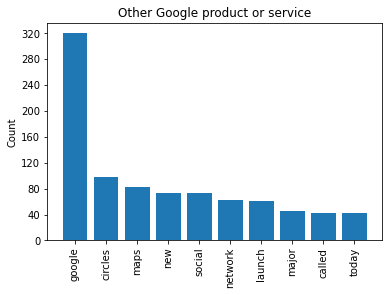

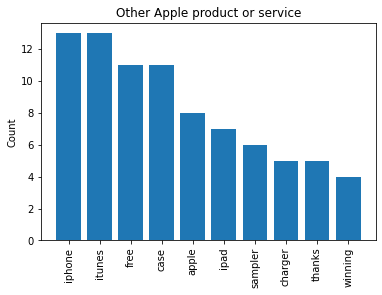

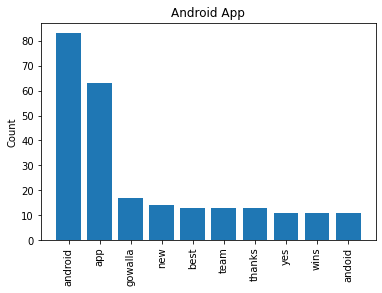

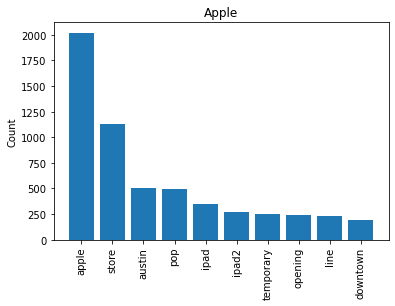

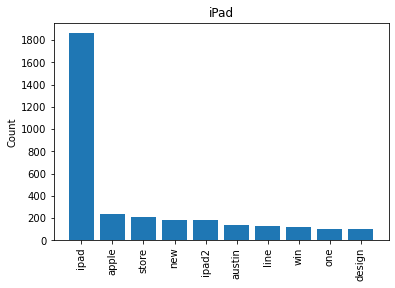

In [44]:
freq_distribution_by_subject(df)

Most of these are probably not needed as the max word count is quite low, we will keep them for now.

# Modeling
I'm going to start by using MultinomialNB and potentially iterating to a deep learning neural net to determine sentimet

In [45]:
df.head()

,tweet,subject,emotion,tweet_tokenized,tweet_without_stopwords
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweet...","[wesley83, 3g, iphone, hrs, tweeting, rise_aus..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, wait, ipad, also, sale]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, cr...","[hope, year, festival, crashy, year, iphone, app]"
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, marissa, mayer,..."


In [46]:
# Start by setting up our training and test sets

y = df['emotion']
X = df['tweet']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [47]:
X_train.head()

,tweet
3363,having a great time at the google party #sxswi...
3204,@mention from:ubersocial for iphone now in the...
4460,are you in town for #sxsw? be sure to check in...
2311,the ironic tee has been usurped by the ipad 2 ...
6298,rt @mention marissa mayer: google will connect...


In [48]:
# Check distibution of training set
y_train.value_counts()

emotion                           
No emotion toward brand or product    4032
Positive emotion                      2259
Negative emotion                       411
dtype: int64

In [49]:
# Check distibution of test set
y_test.value_counts()

emotion                           
No emotion toward brand or product    1356
Positive emotion                       719
Negative emotion                       159
dtype: int64

In [50]:
#Create Baseline Model, create a TFidVectorizer

tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet'])

# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,at,for,google,ipad,link,mention,rt,sxsw,the,to
0,0.561447,0.000000,0.598490,0.000000,0.000000,0.000000,0.000000,0.260088,0.508863,0.000000
1,0.000000,0.523624,0.000000,0.000000,0.388421,0.355803,0.000000,0.219420,0.429298,0.464660
2,0.000000,0.823886,0.397220,0.000000,0.000000,0.000000,0.000000,0.172621,0.000000,0.365555
3,0.320355,0.000000,0.000000,0.341491,0.000000,0.000000,0.000000,0.148403,0.871053,0.000000
4,0.000000,0.000000,0.503358,0.000000,0.387227,0.354709,0.489748,0.218746,0.427978,0.000000
...,...,...,...,...,...,...,...,...,...,...
6697,0.434081,0.000000,0.462720,0.000000,0.355965,0.326072,0.450209,0.402171,0.000000,0.000000
6698,0.468943,0.000000,0.000000,0.000000,0.000000,0.704520,0.486367,0.217235,0.000000,0.000000
6699,0.383120,0.000000,0.000000,0.000000,0.314175,0.287792,0.397356,0.177479,0.694477,0.000000
6700,0.329455,0.000000,0.000000,0.351191,0.000000,0.742439,0.000000,0.152618,0.298599,0.323195


In [51]:
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train['emotion'])
baseline_cv

array([0.60178971, 0.601044  , 0.60149254, 0.60149254, 0.60223881])

In [52]:
y_train.value_counts(normalize=True)

emotion                           
No emotion toward brand or product    0.601611
Positive emotion                      0.337064
Negative emotion                      0.061325
dtype: float64

Ok, so the baseline model is 60% accurate, but based on the distibution, if it only guess no emotion, thats what it would score, lets see if we can raise that value.

### Start by Removing Stopwords

In [53]:
#Removing Stopwords

tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet'])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,apple,austin,circles,google,ipad,iphone,new,social,store
0,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.00000,0.0,0.0,0.000000
1,0.656654,0.00000,0.000000,0.0,0.0,0.0,0.52949,0.0,0.0,0.537072
2,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.00000,0.0,0.0,0.000000
3,0.000000,0.00000,0.000000,0.0,0.0,1.0,0.00000,0.0,0.0,0.000000
4,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.00000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
6697,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.00000,0.0,0.0,0.000000
6698,0.000000,0.00000,0.000000,0.0,0.0,0.0,1.00000,0.0,0.0,0.000000
6699,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000
6700,0.000000,0.00000,0.000000,0.0,0.0,1.0,0.00000,0.0,0.0,0.000000


In [54]:
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train['emotion'])
stopwords_removed_cv

array([0.60253542, 0.61073826, 0.60895522, 0.60671642, 0.59925373])

In [55]:
print(baseline_cv.mean())
print(stopwords_removed_cv.mean())

0.6016115173572851
0.6056398098990506


Removing stopwords is very slightly better so we will keep them removed going forward. Lets now begin stemming words as well.

In [56]:
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [57]:
tfidf = TfidfVectorizer(max_features=10, 
                        stop_words=stemmed_stopwords, 
                        tokenizer=stem_and_tokenize)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet'])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,appl,austin,circl,googl,ipad,iphon,launch,new,store
0,0.00000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000
1,0.63101,0.000000,0.000000,0.0,0.0,0.0,0.545373,0.0,0.0,0.551720
2,0.00000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000
3,0.00000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000
4,0.00000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
6697,0.00000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000
6698,0.00000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000
6699,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
6700,0.00000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000


In [58]:
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train['emotion'])
stemmed_cv

array([0.59731544, 0.61222968, 0.60746269, 0.60223881, 0.59552239])

In [59]:
print(baseline_cv.mean())
print(stopwords_removed_cv.mean())
print(stemmed_cv.mean())

0.6016115173572851
0.6056398098990506
0.6029537992364797


Well I didn't really expect that to do better after seeing it removed the letter e from many important words. Is sentance tokenizing valuable? Most tweets are single sentances regardless when capped at 140 or 280 characters...

In [60]:
df["num_sentences"] = df["tweet"].apply(lambda x: len(sent_tokenize(x)))

In [61]:
def freq_sent_distribution_by_emotion(df):
    emotions = set(df['emotion'].values.tolist())

    #in the loop, create a freq dist for only a subject, then call the visualize freq dist
    
    for em in emotions:
        emotion_df = df[df['emotion'] == em]
        emotion_df_freq_dist = FreqDist(emotion_df["num_sentences"].explode())
        visualize_top_10(emotion_df_freq_dist, em)

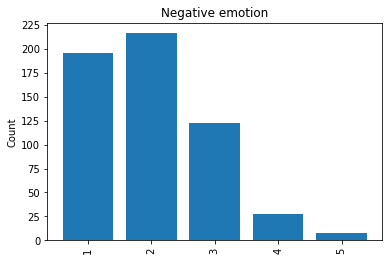

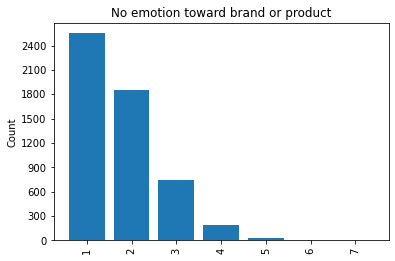

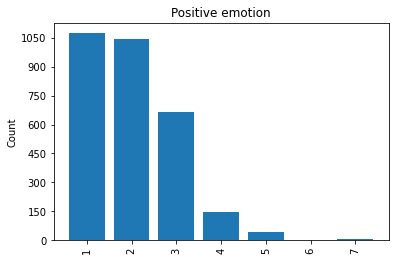

In [62]:
freq_sent_distribution_by_emotion(df)

Ok maybe I'm wrong about what I expected, lets try creating another model and seeing if this can help.

In [63]:
X_train["num_sentences"] = X_train['tweet'].apply(lambda x: len(sent_tokenize(x)))
X_train.num_sentences.value_counts()

1    2911
2    2312
3    1133
4     277
5      62
6       4
7       3
Name: num_sentences, dtype: int64

Lets try adding an emoticons deature as well

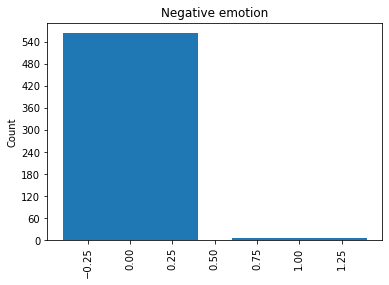

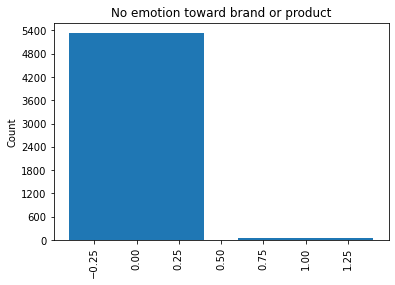

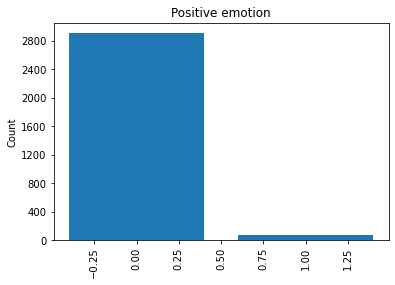

In [64]:
# Emoticons

emoticon_query = r'(?:[\:;X=B][-^]?[)\]3D([OP/\\|])(?:(?=\s))'

df["contains_emoticon"] = df["tweet"].str.contains(emoticon_query)

def freq_distribution_by_emotion(df):
    emotions = set(df['emotion'].values.tolist())

    #in the loop, create a freq dist for only a subject, then call the visualize freq dist
    
    for em in emotions:
        emotion_df = df[df['emotion'] == em]
        emotion_df_freq_dist = FreqDist(emotion_df["contains_emoticon"].explode())
        visualize_top_10(emotion_df_freq_dist, em)

freq_distribution_by_emotion(df)

In [65]:
X_train["contains_emoticon"] = X_train["tweet"].str.contains(emoticon_query)
X_train.head()

,tweet,num_sentences,contains_emoticon
3363,having a great time at the google party #sxswi...,1,False
3204,@mention from:ubersocial for iphone now in the...,1,False
4460,are you in town for #sxsw? be sure to check in...,3,False
2311,the ironic tee has been usurped by the ipad 2 ...,1,False
6298,rt @mention marissa mayer: google will connect...,1,False


In [66]:
X_train.contains_emoticon.value_counts()

False    6600
True      102
Name: contains_emoticon, dtype: int64

In [67]:
X_train.shape

(6702, 3)

In [68]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list,
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet'])

# Create a full df of vectorized + engineered features
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

preprocessed_X_train = pd.concat([X_train_vectorized_df, X_train.reset_index()[["num_sentences", "contains_emoticon"]]], 
                                 axis=1)

preprocessed_X_train

,app,apple,austin,circles,google,ipad,iphone,new,social,store,num_sentences,contains_emoticon
0,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.00000,0.0,0.0,0.000000,1,False
1,0.656654,0.00000,0.000000,0.0,0.0,0.0,0.52949,0.0,0.0,0.537072,1,False
2,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.00000,0.0,0.0,0.000000,3,False
3,0.000000,0.00000,0.000000,0.0,0.0,1.0,0.00000,0.0,0.0,0.000000,1,False
4,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.00000,0.0,0.0,0.000000,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6697,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.00000,0.0,0.0,0.000000,1,False
6698,0.000000,0.00000,0.000000,0.0,0.0,0.0,1.00000,0.0,0.0,0.000000,2,False
6699,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,2,False
6700,0.000000,0.00000,0.000000,0.0,0.0,1.0,0.00000,0.0,0.0,0.000000,2,False


In [69]:
preprocessed_cv = cross_val_score(baseline_model, preprocessed_X_train, y_train['emotion'])
preprocessed_cv

array([0.60850112, 0.61148397, 0.60895522, 0.60447761, 0.59776119])

In [70]:
print(baseline_cv.mean())
print(stopwords_removed_cv.mean())
print(stemmed_cv.mean())
print(preprocessed_cv.mean())

0.6016115173572851
0.6056398098990506
0.6029537992364797
0.6062358231215288


The Preprocessed is the best version but it's still incredibly marginal. How can I increase it?

In [106]:
#Trying more max features

tfidf = TfidfVectorizer(
    max_features=200,
    stop_words=stopwords_list,
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet'])

# Create a full df of vectorized + engineered features
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

final_X_train = pd.concat([X_train_vectorized_df, X_train.reset_index()[["num_sentences", "contains_emoticon"]]], 
                                 axis=1)

final_X_train

,10,11,2011,30,6th,already,also,android,anyone,app,...,win,winning,wins,work,working,would,year,yes,num_sentences,contains_emoticon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300485,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.918663,0.0,1,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,False
6698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2,False
6699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2,False
6700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.461711,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2,False


In [107]:
final_cv = cross_val_score(baseline_model, final_X_train, y_train['emotion'])
final_cv

array([0.6383296 , 0.65175242, 0.64328358, 0.64477612, 0.63955224])

In [108]:
print('baseline: ', baseline_cv.mean())
print('stopwords removed: ', stopwords_removed_cv.mean())
print('stemmed: ', stemmed_cv.mean())
print('preprocessed (-stemmed, + Number of sentances and contains emoticons): ', preprocessed_cv.mean())
print('final (preprocessed + Max Features increased): ', final_cv.mean())

baseline:  0.6016115173572851
stopwords removed:  0.6056398098990506
stemmed:  0.6029537992364797
preprocessed (-stemmed, + Number of sentances and contains emoticons):  0.6062358231215288
final (preprocessed + Max Features increased):  0.643538793727114


### Testing using an SVC instead of MultinomialNB

In [80]:
from sklearn.svm import SVC

svc_clf = SVC(kernel='linear')

In [81]:
svc_cv = cross_val_score(svc_clf, final_X_train, y_train['emotion'])
svc_cv.mean()

0.6609991429875232

## Testing sentiment analysis with VADER

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

#Load the data and preprocess similarly to before

vader_df = pd.read_csv('data-Copy1.csv', engine='python')
vader_df.columns = ['tweet', 'subject', 'emotion']

vader_df['emotion'] = vader_df['emotion'].replace("I can't tell", "No emotion toward brand or product")
vader_df['emotion'] = vader_df['emotion'].replace("No emotion toward brand or product", "No emotion")


vader_df = vader_df.dropna(subset=['tweet'])

vader_df.head()

,tweet,subject,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
vader_df.emotion.value_counts()

No emotion          5544
Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [10]:
vader_df['scores'] = vader_df['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

vader_df.head()

,tweet,subject,emotion,scores
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp..."


In [11]:
vader_df['compound'] = vader_df['scores'].apply(lambda score_dict: score_dict['compound'])

vader_df.head()

,tweet,subject,emotion,scores,compound
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",-0.6800
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...",0.9100
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.7269
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.6249


In [13]:
def emotion_helper(score):
    if score >= .333:
        return "Positive emotion"
    elif score <= -.333:
        return "Negative emotion"
    else:
        return "No emotion"

vader_df['comp_score'] = vader_df['compound'].apply(emotion_helper)

vader_df.head()

,tweet,subject,emotion,scores,compound,comp_score
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",-0.6800,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...",0.9100,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,No emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.7269,Positive emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.6249,Positive emotion


In [15]:
vader_df['Correct'] = vader_df.apply(lambda x: True if x['emotion'] == x['comp_score'] else False, axis=1)


In [16]:
vader_df.head()

,tweet,subject,emotion,scores,compound,comp_score,Correct
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",-0.6800,Negative emotion,True
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...",0.9100,Positive emotion,True
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,No emotion,False
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.7269,Positive emotion,False
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.6249,Positive emotion,True


In [17]:
vader_df.Correct.value_counts()

True     5192
False    3900
Name: Correct, dtype: int64

In [19]:
5192/(3900+5192)

0.5710514738231413

This is worse than my initial attempts going to scrap VADER and move onto something else

# Trying to use BERT

In [98]:
import torch
from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification")

inputs = tokenizer("I Love my girlfriend!", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_ids = torch.arange(0, logits.shape[-1])[torch.sigmoid(logits).squeeze(dim=0) > 0.5]

# To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
num_labels = 3
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=num_labels, problem_type="multi_label_classification"
)

labels = torch.sum(
    torch.nn.functional.one_hot(predicted_class_ids[None, :].clone(), num_classes=num_labels), dim=1
).to(torch.float)
loss = model(**inputs, labels=labels).loss

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

# Neural Net Attempt

In [102]:
# Neural Net imports

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [114]:
#Data cleaning from the start, but shorter

nn_df = pd.read_csv('data-Copy1.csv', engine='python')
nn_df.columns = ['tweet', 'subject', 'emotion']
nn_df = nn_df.drop(unknowns_df.index.tolist())
nn_df = nn_df.dropna(subset=['tweet'])
nn_df['tweet'] = nn_df['tweet'].str.lower()

In [115]:
# Create a tokenizer using the 20,000 most used words
# Fit on the tweets
# Create a list of the tweets
# Set the list of tweets as your training data and pad them for even input into Neural Net

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(nn_df['tweet']))
list_tokenized_tweets = tokenizer.texts_to_sequences(df['tweet'])
X_t = sequence.pad_sequences(list_tokenized_tweets, maxlen=140)

In [117]:
#Set target (y) value as emotion
target = nn_df['emotion']
y = pd.get_dummies(target).values

In [104]:
# Create the model and layers
# Text models should use an embedding layer as the start
# Final layer is 3 for the output size (3 classes)

model = Sequential()

embedding_size = 128
model.add(Embedding(20000, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [105]:
# Compile Model
# Use 'categorical_crossentropy' for multi category classification
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [116]:
# Summary print out
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [121]:
#Train the model
model.fit(X_t, y, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
252/252 [==============================] - 16s 63ms/step - loss: 0.5340 - accuracy: 0.7841 - val_loss: 0.7794 - val_accuracy: 0.6667
Epoch 2/10
252/252 [==============================] - 16s 62ms/step - loss: 0.4553 - accuracy: 0.8165 - val_loss: 0.8727 - val_accuracy: 0.6544
Epoch 3/10
252/252 [==============================] - 16s 64ms/step - loss: 0.3782 - accuracy: 0.8545 - val_loss: 0.9282 - val_accuracy: 0.6667
Epoch 4/10
252/252 [==============================] - 15s 60ms/step - loss: 0.3322 - accuracy: 0.8737 - val_loss: 0.9812 - val_accuracy: 0.6544
Epoch 5/10
252/252 [==============================] - 15s 61ms/step - loss: 0.2965 - accuracy: 0.8847 - val_loss: 1.1116 - val_accuracy: 0.6454
Epoch 6/10
252/252 [==============================] - 17s 66ms/step - loss: 0.2655 - accuracy: 0.8964 - val_loss: 1.2340 - val_accuracy: 0.6577
Epoch 7/10
252/252 [==============================] - 16s 65ms/step - loss: 0.2429 - accuracy: 0.9029 - val_loss: 1.3185 - val_accuracy:

It looks like 3 epochs is actually the sweet spot and anything past that gives diminishing results. At 3 epochs we see .85 accuracy on the training data and .66 accuracy on the validation set. The training accuracy is much higher than our simpler models and the validation accuracy is right around where the training accuracy was so I would say this is a successful test. 